In [90]:
#IMPORT MAIN PACKAGES
import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
#READ MAIN FILE
df = pd.read_pickle("df.pkl")

In [92]:
#DROP PRIMERY KEYS
df.drop(columns=["LEAGUE_ID","TEAM_ID","TEAM_ABBREVIATION"],inplace=True)

In [93]:
#GET ONLY THE FIRST YEAR OF THE SEASON
df['SEASON_ID'] = df['SEASON_ID'].map(lambda x: int(x.split("-",1)[0]))

In [94]:
#CREATE VARIABLE TO SUPPORT STANDARIZATION
num_cols = ['PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK',
       'player_of_week', 'player_of_month']

In [95]:
# STANDARIZATION SEASON BY SEASON
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for year in  df["SEASON_ID"].unique().tolist():
    for col in num_cols:
        df.loc[df['SEASON_ID']==year, col] = scaler.fit_transform(df.loc[df['SEASON_ID']==year, col].to_numpy().reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data

In [96]:
#SAMPLING
train = df.loc[(df['SEASON_ID']>=2000)&(df['SEASON_ID']<=2020),:]
test = df.loc[(df['SEASON_ID']==2021),:]

In [97]:
#SAMPLING
y = train['MVP']
X = train.iloc[:,:-1]

y_test = test['MVP']
X_test = test.iloc[:,:-1]

0    11208
1       21
Name: MVP, dtype: int64


<AxesSubplot:>

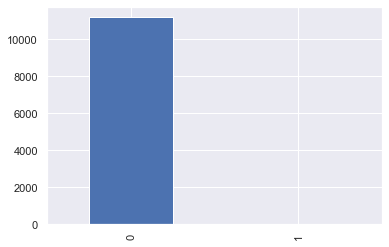

In [98]:
#CHECK VALUES
print(y.value_counts())
y.value_counts().plot(kind='bar')

Feature Selection

Correlation heatmap

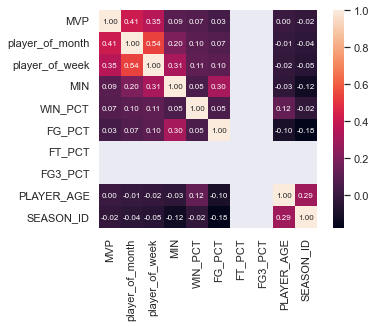

In [99]:
#CORRELATION HEATMAP
corrmat = df.corr()

k = 10 # show top k most correlated features
cols = corrmat.nlargest(k, 'MVP')['MVP'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [100]:
# DROP CORRELATED FEATURES
X_corr = X.corr()
corr_names = set()
for i in range(len(X_corr .columns)):
    for j in range(i):
        if abs(X_corr.iloc[i, j]) > 0.8:
            col = X_corr.columns[i]
            corr_names.add(col)

X.drop(columns=corr_names,inplace=True)
X_test.drop(columns=corr_names,inplace=True)


In [101]:
features = ['PLAYER_AGE', 'GP_player', 'GS', 'MIN', 'FGM_player', 'FGA_player',
       'FG_PCT_player', 'FG3M_player', 'FG3A_player', 'FG3_PCT_player',
       'FTM_player', 'FTA_player', 'FT_PCT_player', 'OREB_player',
       'DREB_player', 'REB_player', 'AST_player', 'STL_player', 'BLK_player',
       'TOV_player', 'PF_player', 'PTS_player', 'WINS','player_of_week', 'player_of_month']

In [102]:
import statsmodels.api as sm
X_logit = X.drop(columns=['PLAYER_ID','SEASON_ID'])
ols = sm.Logit(y,X_logit.astype('float'))
result = ols.fit()
p_values = result.summary2().tables[1]['P>|z|']
p_values = pd.Series(p_values).sort_values(ascending = True)
p_values[p_values<=0.05]

Optimization terminated successfully.
         Current function value: 0.003281
         Iterations 23


player_of_week    0.000003
PLAYER_AGE        0.000148
MIN               0.000187
FG_PCT            0.000721
AST               0.000749
PF                0.007967
GS                0.009774
FTA               0.009836
FTM               0.022049
GP                0.024100
STL               0.026769
Name: P>|z|, dtype: float64

In [103]:
print(result.summary2())

                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.759     
Dependent Variable:  MVP               AIC:               123.6756  
Date:                2022-02-07 12:34  BIC:               306.8319  
No. Observations:    11229             Log-Likelihood:    -36.838   
Df Model:            24                LL-Null:           -152.90   
Df Residuals:        11204             LLR p-value:       5.6153e-36
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      23.0000                                        
--------------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
--------------------------------------------------------------------
PLAYER_AGE       -12.0455   3.1743 -3.7947 0.0001  -18.2670  -5.8240
GP              -236.5829 104.8899 -2.2555 0.0241 -442.1633 -31.0025
GS               284.5698 110.1386  2.5837 0.0098   68.7020 5

0.6296296296296297


Text(0.5, 1.0, 'Lasso Regression')

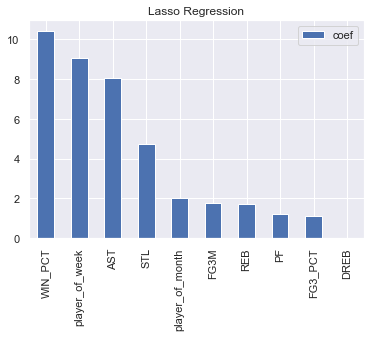

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr =LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=0.5)
lr.fit(X_logit,y)

print(roc_auc_score(lr.predict(X_logit),y))

# plot bar chart 
pd.DataFrame(np.abs(lr.coef_.reshape(-1,1)),index=X_logit.columns,columns=['coef']).sort_values(by=['coef'],ascending=False).head(10).plot(kind='bar')
plt.title("Lasso Regression")

Recursive selection

Text(0.5, 1.0, 'Random Forest')

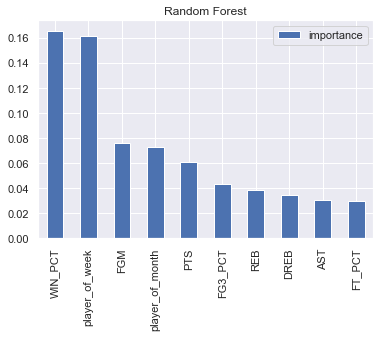

In [105]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=10,random_state=42)
rf.fit(X,y)
importance = pd.DataFrame(rf.feature_importances_,index=X.columns.tolist(),columns=['importance']).sort_values(by='importance',ascending=False)
importance.head(10).plot(kind='bar')
plt.title("Random Forest")

Modeling

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score,roc_auc_score, f1_score,plot_confusion_matrix, plot_roc_curve,plot_precision_recall_curve

model = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=5,
criterion='entropy',max_features='auto',n_estimators=500)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [107]:
print("=====cv score=====")
print("roc_auc_avg:{:.3f}".format(np.mean(scores)))
print("roc_auc_std:{:.3f}".format(np.std(scores)))

=====cv score=====
roc_auc_avg:0.997
roc_auc_std:0.004


In [108]:
model.fit(X,y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=500, random_state=42)

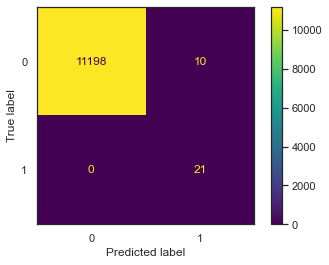

In [109]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
sns.set_style('white')
plot_confusion_matrix(model,X,y)

In [110]:
# fit to test set
result = pd.DataFrame(model.predict_proba(X_test),index = X_test.PLAYER_ID)

result.rename(columns={0:'not',1:'mvp'},inplace=True)

#result['y/n'] = model.predict(X_test)

In [111]:
mvp_candidates = result.sort_values(by='mvp',ascending=False)

In [112]:
mvp_candidates.reset_index(inplace=True)

In [113]:
mvp_candidates.drop(columns=['not'],inplace=True)

In [114]:
from nba_api.stats.static import players
# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()
print('Number of players fetched: {}'.format(len(nba_players)))

Number of players fetched: 4723


In [115]:
nba_players = pd.DataFrame(nba_players)

In [116]:
nba_players.rename(columns={"id":"PLAYER_ID"},inplace = True)

In [117]:
mvp_candidates = mvp_candidates.merge(nba_players.loc[:,['PLAYER_ID','full_name']],on='PLAYER_ID',how='left')

In [118]:
mvp_candidates.head(10)

,PLAYER_ID,mvp,full_name
0,201939,0.485146,Stephen Curry
1,1629027,0.214341,Trae Young
2,201935,0.129451,James Harden
3,1626164,0.113153,Devin Booker
4,1628970,0.076235,Miles Bridges
5,203999,0.075195,Nikola Jokic
6,203507,0.067218,Giannis Antetokounmpo
7,101108,0.058731,Chris Paul
8,1628369,0.046918,Jayson Tatum
9,201942,0.042710,DeMar DeRozan


<function matplotlib.pyplot.show(close=None, block=None)>

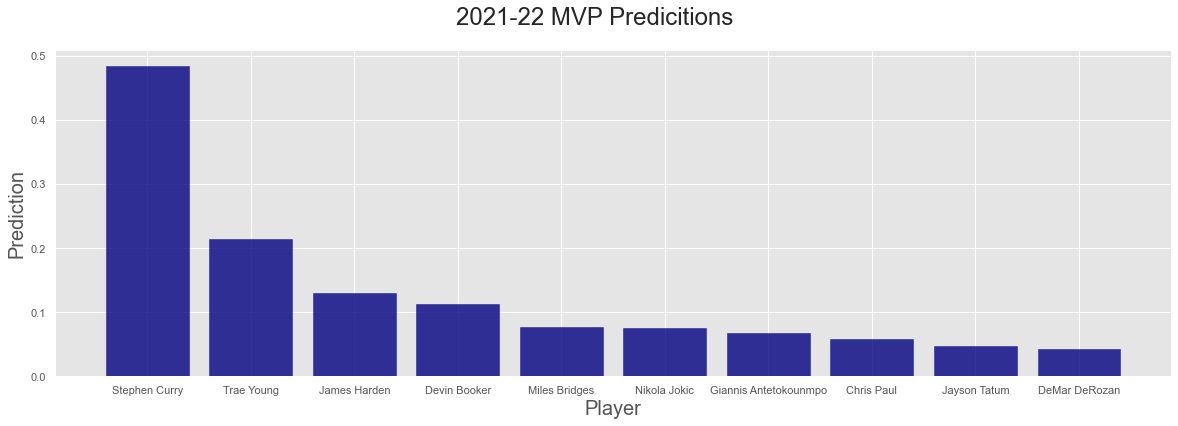

In [159]:
fig, ax = plt.subplots(figsize=(20, 6))


ax.bar(mvp_candidates.head(10)["full_name"],mvp_candidates.head(10)["mvp"], color= "navy", alpha= 0.8, edgecolor = "darkblue")


# title and labels, setting initial sizes
fig.suptitle('2021-22 MVP Predicitions', fontsize=24)
ax.set_xlabel('Player', fontsize=20)
ax.set_ylabel('Prediction', fontsize =20)



fig.savefig("2021-22_MVP_PREDICT.PNG", dpi = 300)

plt.show
